<a href="https://colab.research.google.com/github/Max-FM/seagrass/blob/master/notebooks/predict_seagrass_lizard_island.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Lizard Island Seagrass using Banq d'Arguin trained machine learning model

##Preparing prediction data

###Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Install `seagrass` package

In [2]:
%%capture
!pip install git+https://github.com/Max-FM/seagrass.git

###Open Sentinel 2 and bathymetry GeoTIFFs

In [3]:
from seagrass.raster import open_sentinel2_image

In [4]:
s2_filepath = '/content/drive/MyDrive/Bathymetry/LizardIsland_s2cldmdn.tif'
s2 = open_sentinel2_image(s2_filepath)

###Plot Sentinel 2 image

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

In [41]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def make_composite(band_1, band_2, band_3):
    """Converts three raster bands into a composite image"""
    return normalize(np.dstack((band_1, band_2, band_3)))

def make_s2_rgb(s2_raster):
    red_deglint = s2_raster[2]
    green_deglint = s2_raster[1]
    blue_deglint = s2_raster[0]

    return make_composite(red_deglint, green_deglint, blue_deglint)

(1148, 1715, 3)

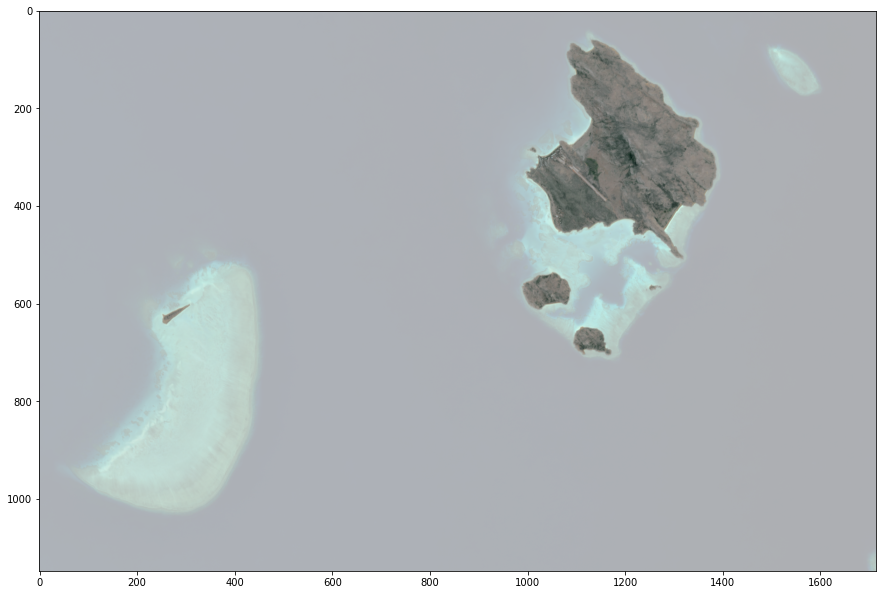

In [42]:
rgb = make_s2_rgb(s2)

plt.figure(figsize=(15,15))
plt.imshow(rgb)


rgb.shape

###Create prediction features

In [9]:
from seagrass.prepare import create_prediction_features
from seagrass.utils import save_prediction_features

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [10]:
%%time

prediction_features = create_prediction_features(s2.values, s2_bands=[3,4,5,6,7,8,9])

CPU times: user 503 ms, sys: 55.6 ms, total: 559 ms
Wall time: 563 ms


In [11]:
display(prediction_features.shape, prediction_features)

(1968820, 14)

array([[0.066375  , 0.0505    , 0.0353    , ..., 0.03304825, 0.03439921,
        0.03261366],
       [0.06815   , 0.05213333, 0.03603333, ..., 0.033099  , 0.03436476,
        0.0326691 ],
       [0.0677    , 0.04846667, 0.0337    , ..., 0.03318274, 0.03432753,
        0.03277548],
       ...,
       [0.09565   , 0.1166    , 0.06866667, ..., 0.04192516, 0.04421957,
        0.03845   ],
       [0.1076    , 0.1299    , 0.075725  , ..., 0.04329496, 0.04574768,
        0.03955978],
       [0.1145    , 0.13946667, 0.08013333, ..., 0.04407161, 0.04660781,
        0.04011484]])

###Save to Modulos compatible tar file

In [12]:
cols = ['b', 'g', 'r', 're1', 're2', 're3', 'nir', 'b_g', 'g_g', 'r_g', 're1_g', 're2_g', 're3_g', 'nir_g']

save_prediction_features('lizard_island_seagrass_prediction.tar', prediction_features, column_labels=cols)

##Generate predictions with Modulos Auto ML

###Copy over ML model and install requirements for predictions

In [13]:
from distutils.dir_util import copy_tree

In [14]:
def copy_solutions(dir, id, dst='.'):
    src = f"{dir}/{id}"
    copy_tree(src, dst)

In [15]:
dir = '/content/drive/Shareddrives/1_Satellite_Derived_Bathymetry & coastal veg/Banc dArguin bathymetry & seagrass/seagrass_ml_models'
# id = '702ffbf9fce54ed0a6975a3bf4aef201'
id = '5634a3781d7a4534a52d8c751f13ae71'

copy_solutions(dir, id)

In [16]:
%%capture

!pip install -r requirements-modules.txt

###Making predictions using trained Modulos ML model

In [17]:
import batch_client as bc 
import os
import shutil

### Set path variables

* **path_to_tar:** Path to the tar file. The tar file has to contain the same data and has to be packed in the same way as the dataset that was uploaded to Modulos.
* **path_to_tmp:** Path to temporary data folder.

In [18]:
path_to_tar = "lizard_island_seagrass_prediction.tar"
path_to_tmp = os.path.join(bc.DEFAULT_OUTPUT_DIR,"tmp_data_dir")

### Run the batch client 

Remove temporary files from previous run:

In [19]:
if os.path.exists(path_to_tmp):
    shutil.rmtree(path_to_tmp)

The batch client takes a `.tar` file as input and outputs predictions in same format as training labels have been. It does so by performing the following steps:
* Creating a temporary directory to save and store intermediate calculations.
* Converting the `.tar` data set into an internal format (HDF5 file). Saved in `path_to_hdf5_data`
* Running the feature extractor on the data.
* Running the model to get predictions.
* Saving the predictions into the same format as training labels have been when training on the platform.

In [20]:
bc.main(dataset_path=path_to_tar, output_dir_user="", verbose=True,
        keep_tmp=True)


Converting dataset ...



Running feature extractor ...  Done.
Running model ...  Done.

Predictions were generated successfully in 
'/content/output_batch_client'.



### Look at the predictions

In [21]:
from IPython.display import HTML
from modulos_utils.solution_utils import jupyter_utils as ju

In [22]:
displayer = ju.JupyterDisplayer.construct(base_dir=bc.FILE_DIR)
HTML(displayer.show())

sample_ids_generated,predictions,b_g,g,g_g,nir,nir_g,r,r_g,re1,re1_g,re2,re2_g,re3,re3_g,b
0,0.000000,0.068232,0.050500,0.050097,0.031733,0.032614,0.035300,0.034828,0.036067,0.036783,0.032925,0.033048,0.034767,0.034399,0.066375
1,0.000000,0.068188,0.052133,0.050172,0.031600,0.032669,0.036033,0.034806,0.036067,0.036697,0.032925,0.033099,0.034767,0.034365,0.068150
2,0.000000,0.068106,0.048467,0.050296,0.029467,0.032775,0.033700,0.034818,0.036700,0.036545,0.033500,0.033183,0.034067,0.034328,0.067700
3,0.000000,0.068030,0.052033,0.050418,0.032800,0.032906,0.035550,0.034925,0.036700,0.036386,0.033500,0.033300,0.034067,0.034331,0.067550
4,0.000000,0.068018,0.049600,0.050488,0.034450,0.033016,0.035867,0.035130,0.035933,0.036302,0.032600,0.033480,0.034250,0.034400,0.066250
5,0.000000,0.068063,0.048750,0.050481,0.031133,0.033069,0.034440,0.035361,0.035933,0.036346,0.032600,0.033732,0.034250,0.034519,0.069600
6,0.000000,0.068102,0.051400,0.050410,0.034400,0.033052,0.036850,0.035510,0.037750,0.036483,0.035950,0.033987,0.035233,0.034630,0.068867
7,0.000000,0.068098,0.050850,0.050324,0.031783,0.032972,0.034867,0.035500,0.036975,0.036596,0.033775,0.034126,0.034942,0.034662,0.067517
8,0.000000,0.068088,0.049650,0.050293,0.031700,0.032868,0.034400,0.035330,0.035750,0.036562,0.032650,0.034067,0.033300,0.034568,0.065933
9,0.000000,0.068116,0.051450,0.050371,0.031900,0.032811,0.033900,0.035077,0.035750,0.036337,0.032650,0.033826,0.033300,0.034348,0.067358


###Convert predictions to raster image

In [23]:
import pandas as pd

df = pd.read_csv('/content/output_batch_client/predictions/predictions.csv')

predictions = df['predictions'].values.reshape(s2.shape[1], s2.shape[2])

In [53]:
#  Normalised Difference Water Index (NDWI)
def ndwi(s2):
    green = s2[4]
    nir = s2[9]
    return (green - nir) / (green + nir)

#  Creates a land pixel mask using the NDWI as a threshold.
def land_mask(s2):
    return ndwi(s2).values < 0    

In [54]:
predictions[land_mask(s2)] = 0
rgb[land_mask(s2)] = 0

In [58]:
def make_seagrass_map(predictions):
    zeros = np.zeros([s2.shape[1], s2.shape[2], 1])
    return np.dstack([predictions, predictions, zeros])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


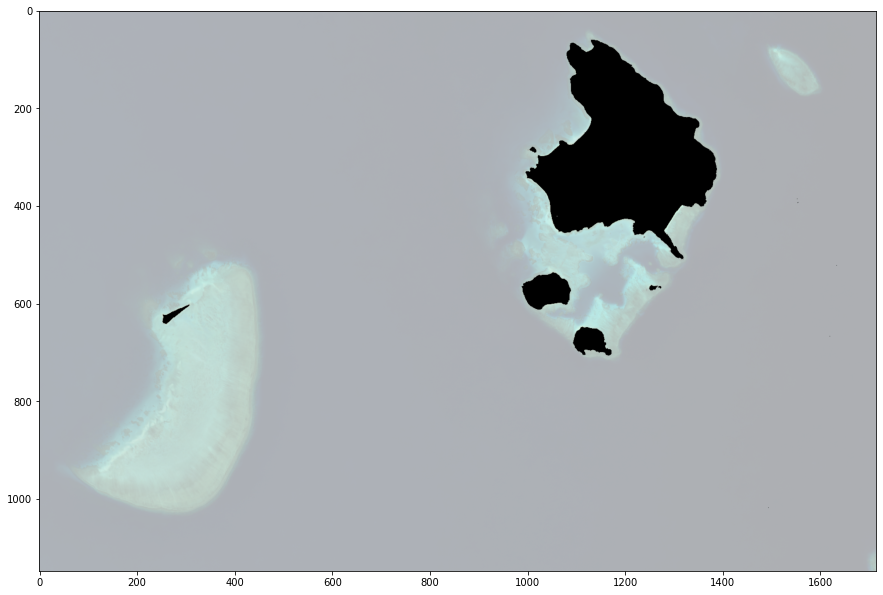

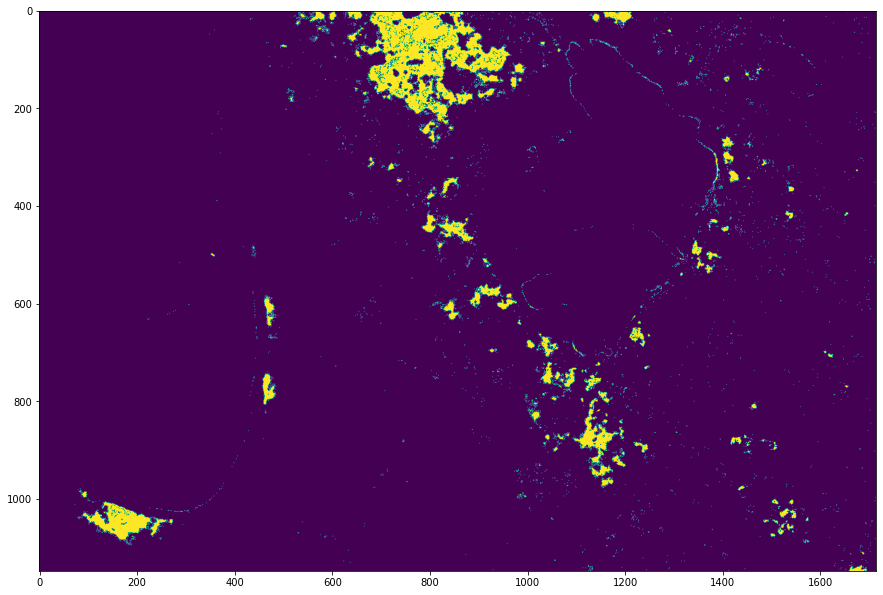

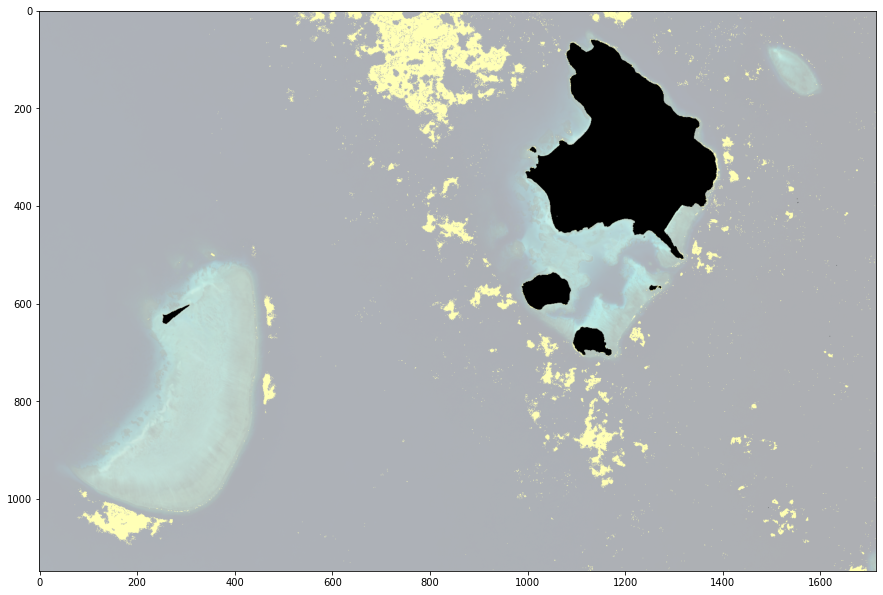

In [59]:
plt.figure(figsize=(15,15))
plt.imshow(rgb)
plt.figure(figsize=(15,15))
plt.imshow(predictions)
plt.figure(figsize=(15,15))
plt.imshow(rgb + make_seagrass_map(predictions))


In [27]:
import rasterio

In [33]:
def save_predictions_tiff(filepath, predictions, sentinel2_crs, sentinel2_transform):
    with rasterio.open(
        filepath,
        'w',
        driver='GTiff',
        height=predictions.shape[0],
        width=predictions.shape[1],
        count=1,
        dtype=predictions.dtype,
        crs=sentinel2_crs,
        transform=sentinel2_transform,
    ) as output_raster:
        output_raster.write(predictions, 1)

In [29]:
# prediction_tiff_dir = '/content/drive/Shareddrives/1_Satellite_Derived_Bathymetry & coastal veg/Lizard Island bathymetry & seagrass/seagrass_predictions'
prediction_tiff_dir = '.'

In [34]:
save_predictions_tiff(f'{prediction_tiff_dir}/lizard_island_seagrass_prediction.tif', predictions, s2.rio.crs, s2.rio.transform())